# Notebook de Exemplos: aproximando raízes de funções.

Este notebook demonstra o uso das seguintes funções de aproximação de raízes:

1.  `bissecao`: Aproxima a raíz utilizando o método da bisseção.

2.  `newton_raphson`: Aproxima a raíz utilizano o método Newton-Raphson.


# Código

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from typing import Callable, Union
        
def bissecao(function: Callable, lower: float, upper: float, tolerance: float, plot: bool = True) -> float:
    '''
    Calcula a raiz aproximada de uma função usando o método da bisseção.

    =============

    Parâmetros:

    function : Função cuja raiz queremos encontrar, deve aceitar apenas um argumento x.
    lower : Limite inferior do intervalo em que queremos calcular a raiz da função.
    upper : Limite superior do intervalo em que queremos calcular a raiz da função.
    tolerance : Valor mínimo que o intervalo pode assumir.

    ============

    Retorna:
    Valor aproximado da raiz da função, arredondado para 4 casas decimais.
    '''
    
    # Listas para salvar os dados para o gráfico
    lower_record = [lower]
    upper_record = [upper]

    # Avalia a função nos pontos limites do intervalo
    lower_bound = function(lower)
    upper_bound = function(upper)
        
    # Verifica se um dos limites do intervalo é raiz
    if lower_bound == 0:
        return round(lower, 4)
    elif upper_bound == 0:
        return round(upper, 4)
            
    # Verifica se a função cumpre as condições para a utilização desse método
    if lower_bound * upper_bound > 0:
        raise ValueError("A função não tem sinais opostos nos limites do intervalo.")
    if tolerance <= 0:
        raise ValueError("Valor de tolerância inválido.")
    
    while upper - lower > tolerance:
        medium_point = (lower + upper) / 2
        medium_value = function(medium_point)
        
        if medium_value == 0:
            return round(medium_point, 4)
        
        if lower_bound * medium_value < 0:
            upper = medium_point
            upper_bound = medium_value
        else:
            lower = medium_point
            lower_bound = medium_value
            
        lower_record.append(lower)
        upper_record.append(upper)
            
    if plot:
        x = np.linspace(lower_record[0], upper_record[0], 100)
        y = function(x)

        plt.axhline(0, color='dimgrey', linewidth=1.5)
        plt.plot(x, y, color='black', linewidth=1.0, label='f(x)') 

        plt.scatter(lower_record, function(np.array(lower_record)), s=20, c='royalblue', label='Limite Inferior', zorder=2)
        plt.scatter(upper_record, function(np.array(upper_record)), s=20, c='crimson', label='Limite Superior', zorder=2)

        plt.xlim(lower_record[0], upper_record[0])
        plt.title("Raízes da função pelo Método da Bisseção")
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.legend()
        plt.show()

    final_root = (lower + upper) / 2
    return round(final_root, 4)

import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from typing import Callable, Union

def newton_raphson(function: Union[Callable, sp.Basic], guess: float, tolerance: float, plot: bool = False) -> float:
    """
    Encontra/aproxima uma raiz de uma função real de variável real usando o método de Newton–Raphson.

    Calcula onde a reta tangente ao gráfico da função no ponto x0 cruza o eixo x.
    Repete o processo com esse novo ponto x1.
    
    Args:
        function Union[Callable, sp.Basic]:
            Função cuja raíz queremos encontrar ou aproximar.
            Pode ser Callable ou sp.Basic.
            Para melhor eficiência do método, deve ser sp.Basic.
        guess (float):
            Chute inicial x0.
        tolerance (float):
            Critério de parada.
            O método para quando |f(x_n)| < tolerance ou |x_{n+1} - x_n| < tolerance.
        plot (bool = False):
            Determina se uma visualização gráfica do método será plotada.
            Por padrão, não é.

    Returns:
        float:
            Valor aproximado da raiz.

    Raises:
        ValueError:
            Se a expressão SymPy tiver mais de uma variável.
            Se ocorrer NaN/Inf em algum momento da iteração.
        TypeError:
            Se function não for Callable ou sp.Basic.
        ZeroDivisionError:
            Se a derivada praticamente zerar em algum momento da iteração.
        RunTimeError:
            Se o método não convergir em no máximo 1000 iterações.
    """

    MAX_ITERS = 1000
    x0 = float(guess)
    x_record = [x0]

    # Preparar f e df: se function for sympy, obtenha a derivada analítca;
    # caso contrário, use derivada numérica por quociente de newton.
    if isinstance(function, sp.Basic):  # cobre sp.Expr, sp.Symbol, etc.
        if isinstance(function, sp.Lambda):
            f_expr = function.expr
            variables = function.variables
        else: # é uma expressão sp.Basic
            f_expr = function
            variables = function.free_symbols

        # Garante que é uma função de uma variável
        if len(variables) == 0:
            # Caso constante
            f = lambda x: float(f_expr)
            df = lambda x: 0.0
        elif len(variables) == 1:
            x_sym = list(variables)[0]
            f = sp.lambdify(x_sym, f_expr, 'numpy')
            
            df_expr = sp.diff(f_expr, x_sym)
            df = sp.lambdify(x_sym, df_expr, 'numpy')
        else:
            raise ValueError(f"A expressão SymPy deve ter exatamente uma variável, mas foram encontradas {len(variables)}: {variables}")
        
    elif callable(function):
        f = function
        def df(x):
            h = 1e-8
            return (f(x + h) - f(x - h)) / (2.0 * h)
    
    # Caso 3: Entrada inválida
    else:
        raise TypeError("function deve ser Callable ou sp.Basic.")
    
    root = None
    for i in range(MAX_ITERS):
        fx = float(f(x0))
        if np.isnan(fx) or np.isinf(fx):
            raise ValueError(f"f(x) retornou {fx} no ponto x = {x0}.")
        # critério pelo valor da função
        if abs(fx) < tolerance:
            root = x0
            break
        dfx = float(df(x0))
        if np.isnan(dfx) or np.isinf(dfx):
            raise ValueError(f"f'(x) retornou {dfx} no ponto x = {x0}.")
        if abs(dfx) < 1e-16:
            raise ZeroDivisionError(f"Derivada muito próxima de zero em x = {x0}.")
        x1 = x0 - fx / dfx
        x_record.append(x1)
        # critério pelo passo
        if abs(x1 - x0) < tolerance:
            root = x1
            break
        x0 = x1
    
    if root is None:
        raise RuntimeError(f"Não convergiu após {MAX_ITERS} iterações. Último x = {x0}, f(x) = {fx}")
    
    # Visualização gráfica
    if plot:
        if len(x_record) > 1:
            x_min = min(x_record)
            x_max = max(x_record)
            delta = (x_max - x_min) * 0.1 if x_max > x_min else 1.0
            x_min -= delta
            x_max += delta
        else:
            x_min = x_record[0] - 1.0
            x_max = x_record[0] + 1.0
        
        x = np.linspace(x_min, x_max, 100)
        y = f(x)
        
        # Plota a função original em preto.
        plt.plot(x, y, color='black', linewidth=1, label='f(x)')
        
        # Plota os pontos de iteração
        x_points_y = f(np.array(x_record))
        plt.plot(x_record, x_points_y, 'ro', label='Pontos de Iteração')
        
        # Plota os segmentos de reta tangente pontilhados
        for j in range(len(x_record) - 1):
            x_i = x_record[j]
            y_i = float(f(x_i))
            x_next = x_record[j + 1]
            x_tang = np.array([x_i, x_next])
            y_tang = df(x_i) * (x_tang - x_i) + y_i
            plt.plot(x_tang, y_tang, 'b--', label='Tangente' if j == 0 else None)
        
        # Plota o eixo x.
        plt.axhline(0, color='black', linewidth=1)
        
        # Configuração do gráfico
        plt.axis('equal')
        plt.title("Raízes da função pelo Método de Newton-Raphson")
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.legend()
        plt.show()
    
    return root

# Testes com o método da bisseção.

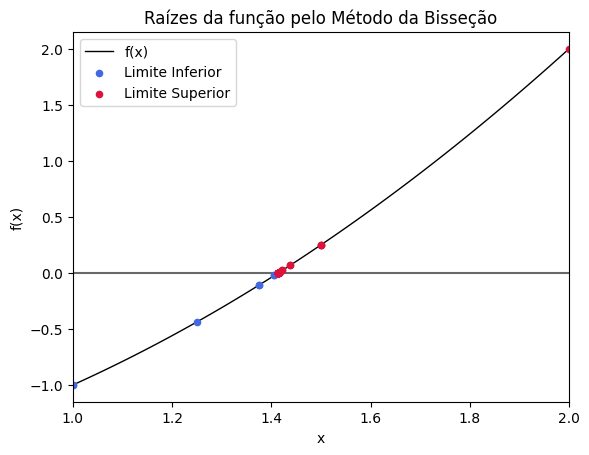

Raiz aproximada: 1.4142
Raiz exata: sqrt(2)


In [11]:
# Função para aproximar a raiz:
f = lambda x: x**2 - 2

# Parâmetros:
limite_inferior = 1.0
limite_superior = 2.0
tolerância = 1e-8

# Aproximação da raíz:
root = bissecao(f, limite_inferior, limite_superior, tolerância)

# Infos
print(f"Raiz aproximada: {root}")
print(f"Raiz exata: sqrt(2)")

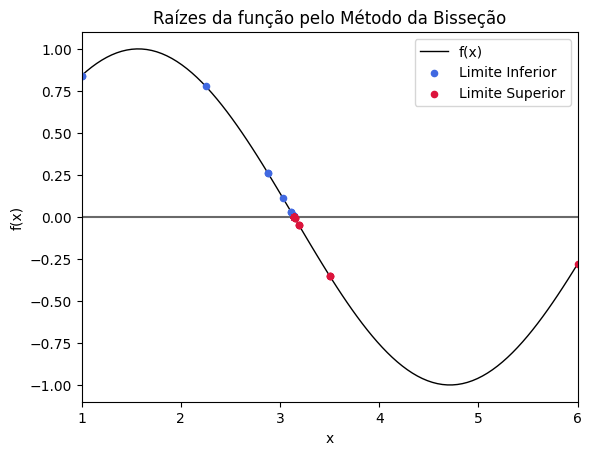

Raiz aproximada: 3.1416
Raiz exata: pi


In [12]:
# Função para aproximar a raiz:
f = lambda x: np.sin(x)

# Parâmetros:
limite_inferior = 1
limite_superior = 6
tolerância = 1e-7

# Aproximação da raíz:
root = bissecao(f, limite_inferior, limite_superior, tolerância)

# Infos
print(f"Raiz aproximada: {root}")
print(f"Raiz exata: pi")

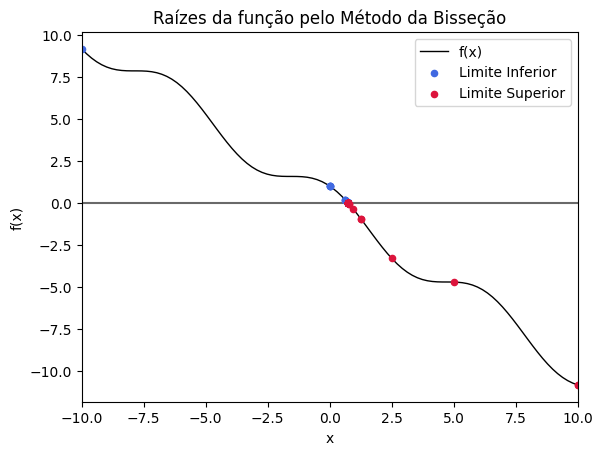

Raiz aproximada: 0.7391


In [13]:
# Função para aproximar a raiz:
f = lambda x: np.cos(x) - x

# Parâmetros:
limite_inferior = -10
limite_superior = 10
tolerância = 1e-9

# Aproximação da raíz:
root = bissecao(f, limite_inferior, limite_superior, tolerância)

# Infos
print(f"Raiz aproximada: {root}")

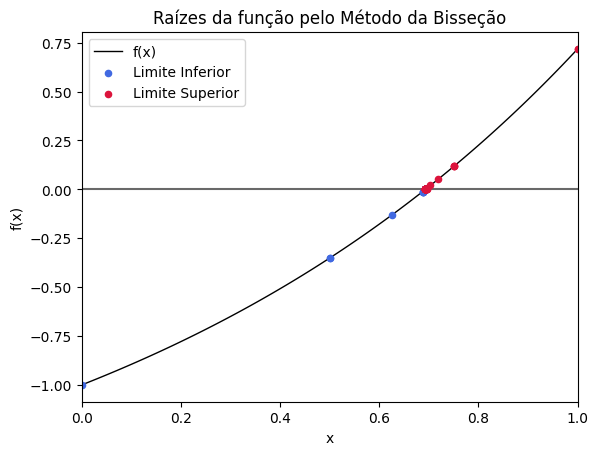

Raiz aproximada: 0.6931
Raiz exata: ln(2)


In [14]:
# Função para aproximar a raiz:
f = lambda x: np.exp(x) - 2

# Parâmetros:
limite_inferior = 0
limite_superior = 1
tolerância = 1e-8

# Aproximação da raíz:
root = bissecao(f, limite_inferior, limite_superior, tolerância)

# Infos
print(f"Raiz aproximada: {root}")
print(f"Raiz exata: ln(2)")

# Testes com o método Newton-Raphson.

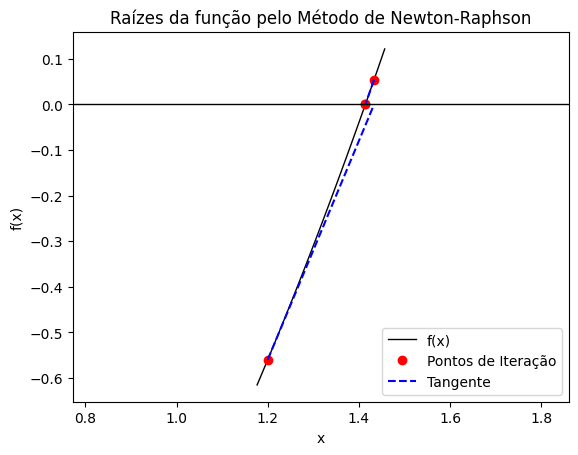

Raiz aproximada: 1.4142
Raiz exata: sqrt(2)


In [15]:
# Função para aproximar a raiz:
f = sp.sympify("x**2 - 2")

# Parâmetros:
chute = 1.2
tolerância = 1e-6

# Aproximação da raíz:
root = newton_raphson(f, chute, tolerância)

# Infos
print(f"Raiz aproximada: {root}")
print("Raiz exata: sqrt(2)")

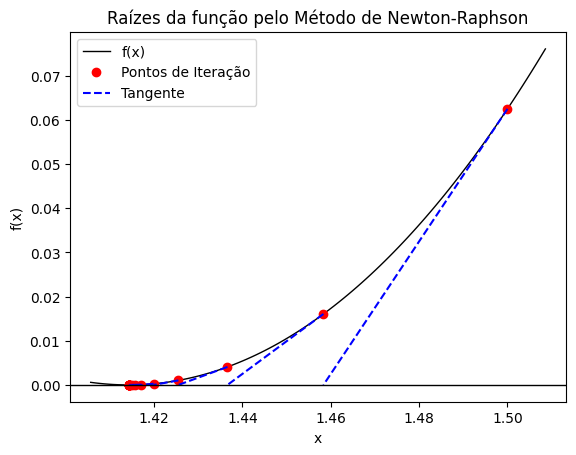

Raiz aproximada: 1.4142
Raiz exata: sqrt(2)


In [16]:
# Função para aproximar a raiz:

f = sp.sympify("x**4 - 4*x**2 + 4")

# Parâmetros:

chute = 1.5
tolerância = 1e-12

# Aproximação da raíz:

root = newton_raphson(f, chute, tolerância)

# Infos

print(f"Raiz aproximada: {root}")
print("Raiz exata: sqrt(2)")


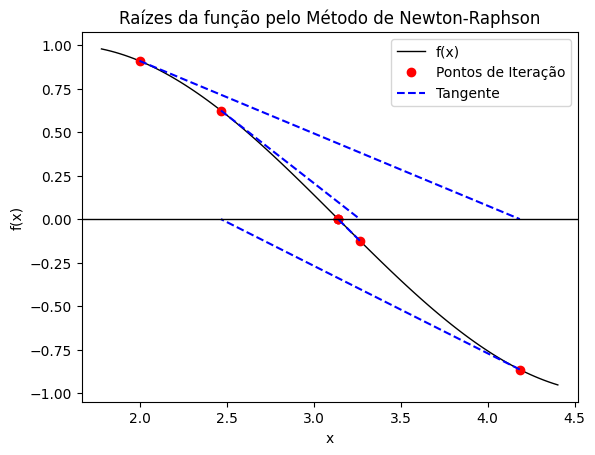

Raiz aproximada: 3.1416
Raiz exata: pi


In [17]:
# Função para aproximar a raiz:

f = sp.sympify("sin(x)")

# Parâmetros:

chute = 2
tolerância = 1e-12

# Aproximação da raíz:

root = newton_raphson(f, chute, tolerância)

# Infos

print(f"Raiz aproximada: {root}")
print("Raiz exata: pi")


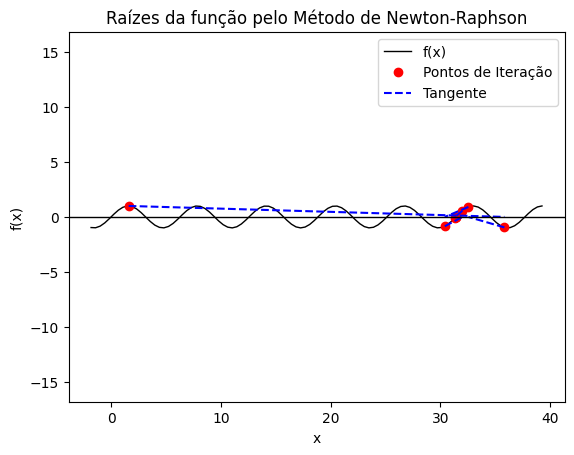

Raiz aproximada: 31.4159


In [18]:
# Função para aproximar a raiz:

f = sp.sympify("sin(x)")

# Parâmetros:

chute = 1.6
tolerância = 1e-12

# Aproximação da raíz:

root = newton_raphson(f, chute, tolerância)

# Infos

print(f"Raiz aproximada: {root}")